# Import everything

In [1]:
import glob
import pandas as pd
import mne
import matplotlib.pyplot as plt
from io import StringIO
import mne
from mne.io import read_raw_eeglab, read_epochs_eeglab
import numpy as np
from scipy import signal
from scipy import fftpack
import seaborn as sns
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
# from tqdm import tqdm, tqdm_notebook
from tqdm.notebook import tqdm
import math
from sklearn import preprocessing
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.svm import SVR
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from keras_tqdm import TQDMNotebookCallback
from tensorboard.plugins.hparams import api as hp
from livelossplot.tf_keras import PlotLossesCallback

import sklearn.model_selection
import sklearn.datasets
import sklearn.metrics
import multiprocessing
from tpot import TPOTRegressor
from oct2py import octave
from joblib import Parallel, delayed
import multiprocessing
from joblib import wrap_non_picklable_objects
import json
import pickle
import os.path
from mpl_toolkits.mplot3d import axes3d
import timeit
from skimage.transform import resize
from timeit import default_timer as timer
from datetime import timedelta
import json
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, optimizers, callbacks
from tensorflow.keras.models import Model, load_model
from tensorboard.plugins.hparams import api as hp
from tensorflow.keras.utils import plot_model
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.genmod import bayes_mixed_glm as glm
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import RFECV
from spectrum import arburg, arma2psd, pburg
import pylab
from scipy.signal import find_peaks, butter
from scipy.integrate import simps
from scipy.io import loadmat
from numpy import trapz

Using TensorFlow backend.
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


# Import some MATLAB libraries
This helps us read .set files.

In [2]:
eeglab_path = '/home/raquib/Documents/MATLAB/eeglab2019_0/functions/'
octave.addpath(eeglab_path + 'guifunc')
octave.addpath(eeglab_path + 'popfunc')
octave.addpath(eeglab_path + 'adminfunc')
octave.addpath(eeglab_path + 'sigprocfunc')
octave.addpath(eeglab_path + 'miscfunc')

'.:/home/raquib/Documents/MATLAB/eeglab2019_0/functions/sigprocfunc:/home/raquib/Documents/MATLAB/eeglab2019_0/functions/adminfunc:/home/raquib/Documents/MATLAB/eeglab2019_0/functions/popfunc:/home/raquib/Documents/MATLAB/eeglab2019_0/functions/guifunc:/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/oct2py:/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/octave_kernel:/usr/lib/x86_64-linux-gnu/octave/4.2.2/site/oct/x86_64-pc-linux-gnu:/usr/lib/x86_64-linux-gnu/octave/site/oct/api-v51/x86_64-pc-linux-gnu:/usr/lib/x86_64-linux-gnu/octave/site/oct/x86_64-pc-linux-gnu:/usr/share/octave/4.2.2/site/m:/usr/share/octave/site/api-v51/m:/usr/share/octave/site/m:/usr/share/octave/site/m/startup:/usr/lib/x86_64-linux-gnu/octave/4.2.2/oct/x86_64-pc-linux-gnu:/usr/share/octave/4.2.2/m:/usr/share/octave/4.2.2/m/audio:/usr/share/octave/4.2.2/m/debian:/usr/share/octave/4.2.2/m/deprecated:/usr/share/octave/4.2.2/m/elfun:/usr/share/octave/4.2.2/m/general:/usr/share/octave/4.2

In [3]:
eegs = sorted(glob.glob('data/original/*/*/eeg/SP 110RMT r*/06-clean-prestimulus-hjorth.mat'))

rejected_trials = [
    {'sub': 'sub03', 'exp': 'exp01', 'run': 'r1', 'trial': '*'}, # We are using exp02 for this one
    {'sub': 'sub03', 'exp': 'exp01', 'run': 'r2', 'trial': '*'}, # We are using exp02 for this one
    {'sub': 'sub03', 'exp': 'exp01', 'run': 'r3', 'trial': '*'}, # We are using exp02 for this one
    
    {'sub': 'sub04', 'exp': 'exp01', 'run': '*', 'trial': '*'},
    
    {'sub': 'sub05', 'exp': 'exp01', 'run': 'r1', 'trial': '*'}, # BAD MEP.
    {'sub': 'sub05', 'exp': 'exp01', 'run': 'r2', 'trial': '*'}, # BAD MEP.
    
    {'sub': 'sub14', 'exp': 'exp01', 'run': '*', 'trial': '*'},
    
    {'sub': 'sub17', 'exp': 'exp01', 'run': 'r1', 'trial': 0}, # Session log mentions there is no pulse.
    {'sub': 'sub17', 'exp': 'exp01', 'run': 'r1', 'trial': 1}, # Session log mentions there is no pulse.
    {'sub': 'sub17', 'exp': 'exp01', 'run': 'r1', 'trial': 48}, # Session log mentions there is no pulse.
    {'sub': 'sub17', 'exp': 'exp01', 'run': 'r1', 'trial': 49}, # Session log mentions there is no pulse.
    {'sub': 'sub22', 'exp': 'exp01', 'run': 'r1', 'trial': 17}, # Session log mentions there is a problem.
    {'sub': 'sub22', 'exp': 'exp01', 'run': 'r1', 'trial': 18}, # Session log mentions there is a problem.
]

# Basic I/O and conversions.

In [4]:
def read_eeg(path):
    eeg = octave.pop_loadset(path)
    new_trial_list = []
    for i in range(eeg.data.shape[2]):
        trial = eeg.data[:, :, i]
        time = np.linspace(-1000, 1000, num=trial.shape[1])
        trial = pd.DataFrame(np.transpose(trial), columns=eeg.chanlocs.labels[0])
        trial['time'] = time
        new_trial_list.append(trial)
    return new_trial_list

def read_trials_from_mat(filename):
    x = loadmat(filename)
    mat_trials = x['dat'][0][0][3][0]
    trials = []
    time = np.linspace(-1000, 1000, len(mat_trials[0][0]))
    for mat_trial in mat_trials:
        trials.append(pd.DataFrame({'C3': mat_trial[0], 'C4': mat_trial[1], 'time': time}))
    return trials

def read_trials_from_mat_avg(filename):
    x = loadmat(filename)
    mat_trials = x['dat'][0][0][3][0]
    trials = []
    time = np.linspace(-1000, 1000, len(mat_trials[0][0]))
    for mat_trial in mat_trials:
        trials.append(pd.DataFrame({
            'FC5': mat_trial[0], 
            'FC3': mat_trial[1], 
            'FC1': mat_trial[2], 
            'C5': mat_trial[3], 
            'C3': mat_trial[4], 
            'C1': mat_trial[5], 
            'CP5': mat_trial[6], 
            'CP3': mat_trial[7], 
            'CP1': mat_trial[8], 
            'FC6': mat_trial[9], 
            'FC4': mat_trial[10], 
            'FC2': mat_trial[11], 
            'C6': mat_trial[12], 
            'C4': mat_trial[13], 
            'C2': mat_trial[14], 
            'CP6': mat_trial[15], 
            'CP4': mat_trial[16], 
            'CP2': mat_trial[17], 
            'time': time
        }))
    return trials

def crop_trials(trial_list, duration_millis=500, sampling_rate=2048):
    new_trial_list = []
    for trial in trial_list:
        samples_to_pick = duration_millis * sampling_rate / 1000
        new_trial_list.append(trial.tail(int(samples_to_pick)))
    return new_trial_list, samples_to_pick

def crop_mep_region(mep_frame, crop_start=0.211, crop_end=0.4):
    multiplier = 7499 / 1.4998
    start = int(crop_start * multiplier)
    end = int(crop_end * multiplier)
    mep_cropped = mep_frame.iloc[start:end, :]
    time = mep_frame.iloc[start:end, :]
    return mep_cropped

def get_apb_column_name(mep_frame):
    if 'L APB' in mep_frame:
        return 'L APB'
    else:
        return 'APB'

def open_mep_as_df(path):
    fileMep = open(path, "r+")
    mep_frames = fileMep.read().split('\n\n')
    df_list = []
    for mep_frame in mep_frames:
        df_list.append(pd.read_csv(StringIO(mep_frame), '\t'))
    return df_list

def get_mep_path(eeg_path):
    segments = eeg_path.split('/')
    segments[4] = 'mep'
    segments = segments[:-1]
    mep_path = '/'.join(segments) + '/*.txt'
    mep_path = glob.glob(mep_path)[0]
    return mep_path

def calculate_mep_size(mep_frame, latency, duration):
    mep_cropped = crop_mep_region(mep_frame, latency, latency + duration)
    apb_name = get_apb_column_name(mep_frame)
    max_row = mep_frame.iloc[mep_cropped.idxmax(axis=0)[apb_name]]
    min_row = mep_frame.iloc[mep_cropped.idxmin(axis=0)[apb_name]]
    mep_size = max_row[apb_name] - min_row[apb_name]
    return mep_size, min_row, max_row

def read_latency_duration(eeg_path):
    segments = eeg_path.split('/')
    sub = segments[2]
    exp = segments[3]
    run = segments[5]
    path = 'data/original/' + sub + '/' + exp + '/mep/' + run + '/01-ld.csv'
    files = glob.glob(path)
    if len(files) < 1:
        return False
    fileMep = open(path, "r+")
    lines = fileMep.read().split('\n')
    df_ld = []
    for frame_txt in lines:
        if 'Frame' in frame_txt:
            continue
        segments = frame_txt.split('\t')
        if len(segments) >= 4:
            df_ld.append({
                'trial_num': int(segments[0])-1,
                'latency': float(segments[2]),
                'duration': float(segments[3]) - float(segments[2])
            })
    return pd.DataFrame(df_ld)

# Read CMAP file.
def read_cmap(path):
    df = pd.read_excel(path, sheet_name='Raw data', header=None)
    columns = []
    ix = 0
    for r in df.index.values:
        if df[0][r] == 'Channel':
            ix = r
            break
    for c in df.columns.values:
        if (df[c][ix] == 2):
            columns.append(c)
    for r in df.index.values:
        if df[0][r] == 'Time (ms)':
            ix = r
            break
    df2 = df[columns].iloc[np.linspace(ix+1, df.shape[0]-2, df.shape[0]-ix-2)]
    df2['time'] = df[0].iloc[np.linspace(ix+1, df.shape[0]-2, df.shape[0]-ix-2)]
    return df2

# Identify CMAP peaks.
def find_cmap_peaks(df):
    df2 = df[(df['time'] > 105) * (df['time'] < 120)]
    time = df2['time']
    mean_clean = np.mean(df2.drop('time', axis=1), axis=1)
    return mean_clean.max(), mean_clean.min()

def get_cmap_path(eeg_path):
    segments = eeg_path.split('/')
    segments[4] = 'cmap'
    del segments[5]
    segments = segments[:-1]
    cmap_path = '/'.join(segments) + '/*.xlsx'
    cmap_paths = glob.glob(cmap_path)
    if (len(cmap_paths) == 0):
        print('No CMAP found for ' + cmap_path)
        return ''
    return cmap_paths[0]

def get_mep_category_absolute_binary(mep_size):
    if mep_size <= .5:
        return 0
    else:
        return 1
    
def calculate_mep_categories_binary(mep_sizes):
    p1 = np.percentile(mep_sizes, 50)
    cat = np.ones(len(mep_sizes)) * (mep_sizes >= p1)
    return cat

def calculate_mep_categories_cmap_binary(mep_sizes, cmap):
    sizes = []
    for mep_size in mep_sizes:
        sizes.append(mep_size / cmap)
    p1 = np.percentile(sizes, 50)
    cat = np.ones(len(mep_sizes)) * (sizes >= p1)
    return cat

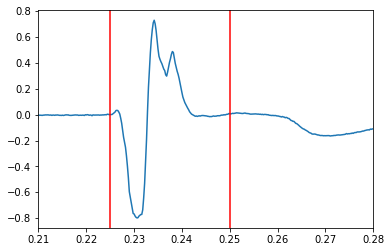

0.0138663662000004


/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/pandas/core/computation/expressions.py:183: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


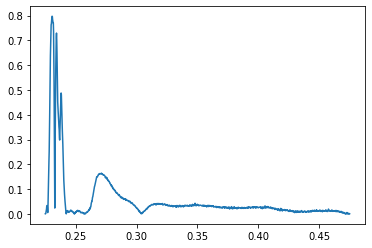

In [5]:
def calculate_mep_area(mep_frame, latency, duration, plot=False):
    apb_name = get_apb_column_name(mep_frame)
    mep_frame = mep_frame[(mep_frame['s'] >= latency) * (mep_frame['s'] <= latency + duration)]
    amplitude = mep_frame[apb_name]
    amplitude = np.abs(amplitude)
    time_diff = mep_frame['s'].iloc[1] - mep_frame['s'].iloc[0]
    area = trapz(amplitude, dx=time_diff)
    if (plot == True):
        plt.plot(mep_frame['s'], amplitude)
    return area
    
frames = open_mep_as_df(get_mep_path(eegs[30]))
mep_frame = frames[5]
plt.plot(mep_frame['s'], mep_frame['L APB'])
plt.xlim(.21, .28)
plt.axvline(0.225, color='r')
plt.axvline(0.25, color='r')
plt.show()
print(calculate_mep_area(mep_frame, 0.225, 0.25, plot=True))

# Power and phase calculations

In [6]:
def blackman_harris_filter(channel, time, cutoffs, fs, numtaps=801):
    b = signal.firwin(numtaps, cutoffs, window='blackmanharris', fs=fs)
    filtered = signal.lfilter(b, 1, channel)
    delay = 0.5 * (numtaps - 1) / fs
    df = pd.DataFrame({
        'time': time-delay,
        'channel': filtered
    })
    return df

def butter_bandpass_filter(data, lowcut, highcut, fs, btype='bandpass', order=2):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype=btype)
    y = signal.lfilter(b, a, data)
    return y

def get_phase(channel, time, band, fs=4096, plot=False, filter_type='butter', start_time_ms=-750, stop_time_ms=-2):
    if filter_type=='butter':
        df_filtered = pd.DataFrame({'channel': butter_bandpass_filter(channel, band[0], band[1], fs), 'time': time})
    else:
        df_filtered = blackman_harris_filter(channel, time, [0.000001, band[0]], fs)
        df_filtered = blackman_harris_filter(df_filtered['channel'].values, df_filtered['time'].values, band[1], fs)    
    
    hilb = signal.hilbert(df_filtered[(df_filtered['time'] > start_time_ms) * (df_filtered['time'] < stop_time_ms)]['channel'])
    phase = np.angle(hilb, deg=True)
    df_phase = pd.DataFrame(phase, columns=['phase'])
    df_phase['time'] = df_filtered[(df_filtered['time'] > start_time_ms) * (df_filtered['time'] < stop_time_ms)]['time'].values
    
    if plot == True:
        fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(13,10))
        ax1.plot(time, channel)
        ax1.set_xlabel('Time')
        ax1.set_ylabel('Amplitude')
        ax1.set_title('Signal')
        
        ax2.plot(df_filtered['time'], df_filtered['channel'])
        ax2.set_title('Filtered channel')
        ax2.set_xlabel('Time')
        ax2.set_ylabel('Filtered channel')
        
        freq, power = signal.welch(df_filtered['channel'], 4096, nperseg=4096/2, nfft=4096/2)
        freq_res = freq[1] - freq[0]
        power = np.log(power)
        ax3.plot(freq[freq < 200], power[freq < 200])
        ax3.set_title('Power spectrum')
        ax3.set_xlabel('Frequency')
        ax3.set_ylabel('Power')
        
        ax4.plot(df_phase['time'], df_phase['phase'])
        ax4.plot(df_phase.iloc[-1]['time'], df_phase.iloc[-1]['phase'], 'o')
        ax4.set_title('Phase')
        ax4.set_xlabel('Time')
        ax4.set_ylabel('Phase')
        plt.tight_layout()
    # df_phase = df_phase[df_phase['time'] <= -20]
    return df_phase.iloc[-1]['phase'] + 180

def get_power(channel, time, crop_start_millis=-150, fs=500, method='pburg', filter_type='butter'):       
    # Crop.
    channel = channel[(time > crop_start_millis) * (time < -1)].values
    time = time[(time > crop_start_millis) * (time < -1)].values

    # Resample.
    ts = time[1] - time[0]
    secs = len(channel) * ts
    secs = secs/1000
    resampled = signal.resample(channel, int(secs*fs))
    resampled_time = np.linspace(time[0], time[-1], len(resampled))
    
    # Filer if gamma region.
#     if 48 > band[0] and 48 < band[1]:
    if filter_type == 'butter':
        resampled = butter_bandpass_filter(resampled, 48, 52, fs, 'bandstop')
        resampled_time = resampled_time
    else:
        df_filtered = blackman_harris_filter(resampled, resampled_time, [48, 52], fs, numtaps=101)
        resampled = df_filtered['channel']
        resampled_time = df_filtered['time']
    
    # PSD.
    try:
        if method == 'welch':
            # Welch method
            freq, power = signal.welch(resampled, fs, nfft=2*fs)
            freq_res = freq[1] - freq[0]
            df_power = pd.DataFrame({'freq': freq, 'power': 10*np.log10(power)})
            # df_power_in_band = df_power[(df_power['freq'] >= band[0]) * (df_power['freq'] <= band[1])]
            # mean_power = np.mean(df_power_in_band['power'])
            # idx_band = np.logical_and(freq >= band[0], freq <= band[1])
            # mean_power = simps(power[idx_band], dx=freq_res)
        elif method == 'fft':
            # FFT method
            power = np.abs(np.fft.fft(resampled, n=2*fs))
            freq = np.linspace(0, fs, len(power))
            df_power = pd.DataFrame({'freq': freq, 'power': 10*np.log10(power)})
            # df_power_in_band = df_power[(df_power['freq'] >= band[0]) * (df_power['freq'] <= band[1])]
            # mean_power = np.mean(df_power_in_band['power'])
        elif method == 'pburg':
            # Burgs method
            p = pburg(resampled, int(len(resampled)*.5), sampling=fs, NFFT=2000)
            power = p.psd
            freq = np.linspace(0, fs, len(power))
            df_power = pd.DataFrame({'freq': freq, 'power': 10*np.log10(power)})
            # df_power_in_band = df_power[(df_power['freq'] >= band[0]) * (df_power['freq'] <= band[1])]
            # mean_power = np.mean(df_power_in_band['power'])
    except:
        return 0

    df_power = df_power[df_power['freq'] < fs/2]
    return df_power

# Combine EEG and others

In [7]:
def calculate_power_phase(trial, channel):    
    phase_power_dict = {} 
    
    # −4500ms and −500ms
    # -752ms to -2ms
    # -152ms to -2ms
    
    for filter_name in ['butter', 'blackmanharris']:
        phase_power_dict['theta_phase_' + filter_name] = get_phase(trial[channel], trial['time'], [3.5, 8], filter_type=filter_name)
        phase_power_dict['mu_phase_' + filter_name] = get_phase(trial[channel], trial['time'], [8, 12], filter_type=filter_name)
        phase_power_dict['beta_phase_' + filter_name] = get_phase(trial[channel], trial['time'], [13, 30], filter_type=filter_name)
        phase_power_dict['gamma_phase_' + filter_name] = get_phase(trial[channel], trial['time'], [30, 80], filter_type=filter_name)
        phase_power_dict['low_beta_phase_' + filter_name] = get_phase(trial[channel], trial['time'], [12, 20], filter_type=filter_name)
        phase_power_dict['high_beta_phase_' + filter_name] = get_phase(trial[channel], trial['time'], [20, 30], filter_type=filter_name)
        phase_power_dict['low_gamma_phase_' + filter_name] = get_phase(trial[channel], trial['time'], [30, 46], filter_type=filter_name)
        phase_power_dict['high_gamma_phase_' + filter_name] = get_phase(trial[channel], trial['time'], [46, 70], filter_type=filter_name)

    for filter_name in ['butter', 'blackmanharris']:
        for method in ['pburg', 'welch', 'fft']:
            for crop_start in [-150, -750]:
                df_power = get_power(trial[channel], trial['time'], method=method, filter_type=filter_name, crop_start_millis=crop_start)
                phase_power_dict['theta_power_' + filter_name + '_' + method + '_' + str(crop_start)] = df_power[(df_power['freq'] > 3.5) * (df_power['freq'] <= 8)]['power'].mean()
                phase_power_dict['mu_power_' + filter_name + '_' + method + '_' + str(crop_start)] = df_power[(df_power['freq'] > 8) * (df_power['freq'] <= 12)]['power'].mean()
                phase_power_dict['beta_power_' + filter_name + '_' + method + '_' + str(crop_start)] = df_power[(df_power['freq'] > 13) * (df_power['freq'] <= 30)]['power'].mean()
                phase_power_dict['gamma_power_' + filter_name + '_' + method + '_' + str(crop_start)] = df_power[(df_power['freq'] > 30) * (df_power['freq'] <= 80)]['power'].mean()
                phase_power_dict['low_beta_power_' + filter_name + '_' + method + '_' + str(crop_start)] = df_power[(df_power['freq'] > 12) * (df_power['freq'] <= 20)]['power'].mean()
                phase_power_dict['high_beta_power_' + filter_name + '_' + method + '_' + str(crop_start)] = df_power[(df_power['freq'] > 20) * (df_power['freq'] <= 30)]['power'].mean()
                phase_power_dict['low_gamma_power_' + filter_name + '_' + method + '_' + str(crop_start)] = df_power[(df_power['freq'] > 30) * (df_power['freq'] <= 46)]['power'].mean()
                phase_power_dict['high_gamma_power_' + filter_name + '_' + method + '_' + str(crop_start)] = df_power[(df_power['freq'] > 46) * (df_power['freq'] <= 70)]['power'].mean()
    
    return phase_power_dict
        
def process_trials(eeg_path):
    print('Processing block: {}'.format(eeg_path))
    sub = eeg_path.split('/')[2]
    exp = eeg_path.split('/')[3]
    run = eeg_path.split('/')[5]
    
    files = glob.glob(os.path.dirname(eeg_path) + "/010-raw-hjorth.mat")
    if (len(files) == 0):
        return []
    
    trials_hjorth = read_trials_from_mat(os.path.dirname(eeg_path) + "/010-raw-hjorth.mat")
    # trials_raw = read_eeg(os.path.dirname(eeg_path) + "/06-clean-prestimulus.set")
    trials_raw = pickle.load(open(os.path.dirname(eeg_path) + "/raw.p", "rb"))

    # Calculate CMAP.
    try:
        cmap_max, cmap_min = find_cmap_peaks(read_cmap(get_cmap_path(eeg_path)))
        cmap = cmap_max - cmap_min
    except:
        cmap = 0
    
    # Read latency duration
    df_ld = read_latency_duration(eeg_path)
    if isinstance(df_ld, pd.DataFrame) == False:
        return []
    
    # Calculate powers and phases. And combine the results in a df list.
    power_phase_list = []
    for trial_num in df_ld['trial_num'].values:
        if len(trials_hjorth)-1 < trial_num:
            continue
        trial_hjorth = trials_hjorth[trial_num]
        trial_raw = trials_raw[trial_num]
    
        # Ignore rejected trials.
        break_loop = False
        for rejected in rejected_trials:
            if (sub == rejected['sub']) and (exp == rejected['exp']) and (rejected['run'] == run.split(' ')[2]) and ((rejected['trial'] == trial_num) or (rejected['trial'] == '*')):
                print('Rejecting ' + sub + '/' + exp + '/' + run + '/' + str(rejected['trial']))
                break_loop = True
                break
        if break_loop == True or df_ld[df_ld['trial_num'] == trial_num].shape[0] == 0:
            continue
        
        # Calculate phase and power.
        # print('Processing ' + sub + '/' + exp + '/' + run + '/' + str(trial_num))
        try:
            if sub in ['sub13', 'sub02']:
                channel = 'C4'
            else:
                channel = 'C3'
            
            # Average channel
            trial_avg = trial_raw.copy()
            c3 = trial_raw[['FC5', 'FC3', 'FC1', 'C5', 'C3', 'C1', 'CP5', 'CP3', 'CP1']].mean(axis=1)
            c4 = trial_raw[['FC6', 'FC4', 'FC2', 'C6', 'C4', 'C2', 'CP6', 'CP4', 'CP2']].mean(axis=1)
            trial_avg['C3'] = c3
            trial_avg['C4'] = c4
            
            # Calculate powers and phases
            power_hjorth = calculate_power_phase(trial_hjorth, channel)
            power_raw = calculate_power_phase(trial_raw, channel)
            power_avg = calculate_power_phase(trial_avg, channel)
        except ValueError as e:
            print('Skipping ' + sub + '/' + exp + '/' + run + '/' + str(trial_num) + ': ' + str(e))
            continue

        latency = df_ld[df_ld['trial_num'] == trial_num].iloc[0]['latency']
        duration = df_ld[df_ld['trial_num'] == trial_num].iloc[0]['duration']
        mep_frame = open_mep_as_df(get_mep_path(eeg_path))[trial_num]
        mep_size, _, _ = calculate_mep_size(mep_frame, latency, duration)
        
        
        power_dict = dict()
        for key in power_hjorth.keys():
            power_dict[key + '_' + 'hjorth'] = power_hjorth[key]
        for key in power_raw.keys():
            power_dict[key + '_' + 'raw'] = power_raw[key]
        for key in power_avg.keys():
            power_dict[key + '_' + 'avg'] = power_avg[key]
        
        power_phase_dict = power_dict
        power_phase_dict['sub'] = sub
        power_phase_dict['exp'] = exp
        power_phase_dict['run'] = run
        power_phase_dict['trial_num'] = trial_num
        power_phase_dict['cmap'] = cmap
        power_phase_dict['mep_size'] = mep_size

        power_phase_dict['mep_latency'] = latency - 0.20
        power_phase_dict['mep_duration'] = duration
        power_phase_dict['mep_area'] = calculate_mep_area(mep_frame, latency, duration)
        
        power_phase_dict['rejected'] = False
        for rejected in rejected_trials:
            if (sub == rejected['sub']) and (exp == rejected['exp']) and (rejected['run'] == run.split(' ')[2]) and ((rejected['trial'] == trial_num) or (rejected['trial'] == '*')):
                power_phase_dict['rejected'] = True
                break

        power_phase_list.append(power_phase_dict)
    return power_phase_list

In [8]:
# Run analysis
num_cores = multiprocessing.cpu_count() - 2
results = Parallel(n_jobs=num_cores)(delayed(process_trials)(eeg_path) for eeg_path in tqdm(eegs))

# results = []
# for eeg_path in tqdm(eegs):
#     result = process_trials(eeg_path)
#     if len(result) > 0:
#         results.append(result)

df_power = []
for result in tqdm(results):
    if len(result) > 0:
        for trial in result:
            df_power.append(trial)

df_power = pd.DataFrame(df_power)

/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


In [9]:
sub_map = {
    'sub01': 'Terry Baedon',
    'sub02': 'David Brown',
    'sub03': 'Sarah Brunet',
    'sub04': 'Lynette Gallaty',
    'sub05': 'Mana Higashihara',
    'sub06': 'Tim Howells',
    'sub07': 'Merolene Pirsarkiewicz',
    'sub08': 'Steve Vucic',
    'sub09': 'Hayeley Turnbull',
    'sub10': 'Nimeshan Geevasinga',
    'sub11': 'Amarissa M',
    'sub12': 'Marshall Owen',
    'sub13': 'Stephen Schebeci',
    'sub14': 'Matt Silsby',
    'sub15': 'Carlos Brito',
    'sub16': 'Alistair McEwan',
    'sub17': 'Toni Mathieson',
    'sub18': 'Karen Robertson',
    'sub19': 'Julie Terry',
    'sub20': 'Natalie Terry',
    'sub21': 'Raquib-ul Alam',
    'sub22': 'Lin Gavin',
}

# Insert subject names
df_power['name'] = df_power.apply(lambda x: sub_map[x['sub']], axis=1)

,beta_phase_blackmanharris_avg,beta_phase_blackmanharris_hjorth,beta_phase_blackmanharris_raw,beta_phase_butter_avg,beta_phase_butter_hjorth,beta_phase_butter_raw,beta_power_blackmanharris_fft_-150_avg,beta_power_blackmanharris_fft_-150_hjorth,beta_power_blackmanharris_fft_-150_raw,beta_power_blackmanharris_fft_-750_avg,...,theta_power_butter_pburg_-750_raw,theta_power_butter_welch_-150_avg,theta_power_butter_welch_-150_hjorth,theta_power_butter_welch_-150_raw,theta_power_butter_welch_-750_avg,theta_power_butter_welch_-750_hjorth,theta_power_butter_welch_-750_raw,trial_num,name,sub_exp
0,253.197310,259.227960,253.475177,233.954755,244.741252,237.186607,30.155415,33.097893,34.142390,30.751833,...,35.023043,16.019406,26.084887,26.390426,1.681325,14.260379,13.314360,0,David Brown,sub02_exp01
1,322.400698,246.063099,248.071766,66.119962,84.336268,73.301890,17.712250,30.494485,29.901573,20.445276,...,30.272737,-8.406083,22.313550,21.668388,0.113583,15.043557,12.431390,1,David Brown,sub02_exp01
2,46.728018,264.748856,329.038066,227.576249,20.586940,226.329212,19.142364,25.723800,25.259891,20.016527,...,8.385803,-4.967340,4.550070,-1.289127,-6.839048,-4.861967,1.168434,2,David Brown,sub02_exp01
3,293.282000,250.572377,263.099207,247.339432,92.334537,244.464456,20.059061,23.363440,24.213758,21.318396,...,8.909830,-11.122409,0.209918,0.783704,-1.631370,-1.765901,3.367332,3,David Brown,sub02_exp01
4,58.418758,268.417886,333.578930,48.719970,257.958866,1.841685,21.560814,24.785412,24.726407,22.454398,...,11.034152,-2.394430,4.257885,3.349184,-3.799718,4.943934,4.663004,4,David Brown,sub02_exp01


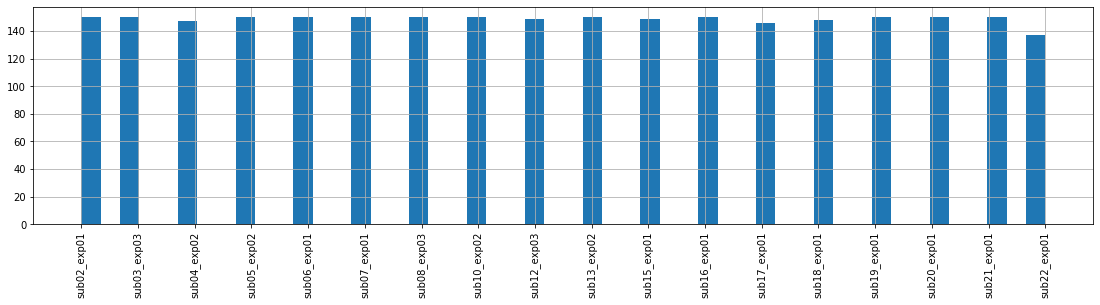

In [10]:
# Show subject histogram and remove subjects with fewer trials
df_power['sub_exp'] = df_power['sub'] + "_" + df_power['exp']
df_power = df_power[~df_power['sub_exp'].isin(['sub04_exp01', 'sub14_exp01'])]
df_power['sub_exp'].hist(figsize=(19,4), xrot=90, bins=50, align='mid')

# Save the dataframe
df_power.to_excel('159-d1-power-phase-wide.xlsx')
df_power.head()

In [18]:
df_power = pd.read_excel('159-d1-power-phase-wide.xlsx')

In [11]:
# Long format - power
value_vars = []
for eeg_type in ['hjorth', 'raw', 'avg']:
    for filter_type in ['butter', 'blackmanharris']:
        for band in ['theta', 'mu', 'beta', 'gamma']:
            for time in ['-750', '-150']:
                for method in ['fft', 'welch', 'pburg']:
                    value_vars.append(band + '_power_' + filter_type + '_' + method + '_' + time + '_' + eeg_type)
df_melt = pd.melt(df_power, id_vars=['sub', 'exp', 'run', 'trial_num', 'mep_size', 'mep_latency', 'mep_duration'], value_vars=value_vars)

# Rename some variables
method_map = dict()
method_map = {
    'fft': 'FFT',
    'welch': 'Welch',
    'pburg': 'Burg'
}
eeg_type_map = {
    'raw': 'Raw',
    'hjorth': 'Hjorth',
    'avg': 'Average'
}
filter_map = {
    'blackmanharris': 'Blackman-Harris',
    'butter': 'Butterworth'
}
df_melt['Method'] = df_melt['variable'].apply(lambda x: method_map[x.split('_')[3]])
df_melt['Band'] = df_melt['variable'].apply(lambda x: x.split('_')[0].capitalize())
df_melt['Filter'] = df_melt['variable'].apply(lambda x: filter_map[x.split('_')[2]])
df_melt['Time'] = df_melt['variable'].apply(lambda x: str(x.split('_')[4]))
df_melt['EEG'] = df_melt['variable'].apply(lambda x: eeg_type_map[x.split('_')[5]])

# Generate absolute trial numbers
df_melt = df_melt.sort_values(['Method', 'Band', 'Filter', 'Time', 'EEG', 'sub', 'exp', 'run', 'trial_num'])
df_new = []
for method in tqdm(['Burg', 'FFT', 'Welch']):
    for band in tqdm(['Theta', 'Mu', 'Beta', 'Gamma']):
        for filt in ['Blackman-Harris', 'Butterworth']:
            for time in ['-750', '-150']:
                for eeg in ['Average', 'Raw', 'Hjorth']:
                    for sub in df_melt['sub'].unique():
                        i = 0
                        df_sub = df_melt[df_melt['Method'] == method]
                        df_sub = df_sub[df_sub['Band'] == band]
                        df_sub = df_sub[df_sub['Filter'] == filt]
                        df_sub = df_sub[df_sub['Time'] == time]
                        df_sub = df_sub[df_sub['EEG'] == eeg]
                        df_sub = df_sub[df_sub['sub'] == sub]
                        for idx, row in df_sub.iterrows():
                            row = row.to_dict()
                            row['trial_abs'] = i
                            df_new.append(row)
                            i = i+1
df_melt = pd.DataFrame(df_new)
df_melt = df_melt.reset_index()
print(df_melt.shape)
df_melt.to_excel('159-d1-power-long.xlsx')



(385344, 16)


In [12]:
# Long format - phase
value_vars = []
for eeg_type in ['hjorth', 'raw', 'avg']:
    for filter_type in ['butter', 'blackmanharris']:
        for band in ['theta', 'mu', 'beta', 'gamma']:
            value_vars.append(band + '_phase_' + filter_type + '_' + eeg_type)
df_melt = pd.melt(df_power, id_vars=['sub', 'exp', 'run', 'trial_num', 'mep_size', 'mep_latency', 'mep_duration', 'mep_area'], value_vars=value_vars)

# Rename some variables
df_melt['Band'] = df_melt['variable'].apply(lambda x: x.split('_')[0].capitalize())
df_melt['Filter'] = df_melt['variable'].apply(lambda x: filter_map[x.split('_')[2]])
df_melt['EEG'] = df_melt['variable'].apply(lambda x: eeg_type_map[x.split('_')[3]])

# Generate absolute trial numbers
df_melt = df_melt.sort_values(['Band', 'Filter', 'EEG', 'sub', 'exp', 'run', 'trial_num'])
subs = df_melt['sub'].unique()
df_new = []
for band in tqdm(['Theta', 'Mu', 'Beta', 'Gamma']):
    for filt in ['Blackman-Harris', 'Butterworth']:
        for eeg in ['Raw', 'Hjorth', 'Average']:
            for sub in subs:
                i = 0
                df_sub = df_melt[df_melt['Band'] == band]
                df_sub = df_sub[df_sub['Filter'] == filt]
                df_sub = df_sub[df_sub['EEG'] == eeg]
                df_sub = df_sub[df_sub['sub'] == sub]
                for idx, row in df_sub.iterrows():
                    row = row.to_dict()
                    row['trial_abs'] = i
                    df_new.append(row)
                    i = i+1
df_melt = pd.DataFrame(df_new)
print(df_melt.shape)
df_melt.to_excel('159-d1-phase-long.xlsx')


(64224, 14)


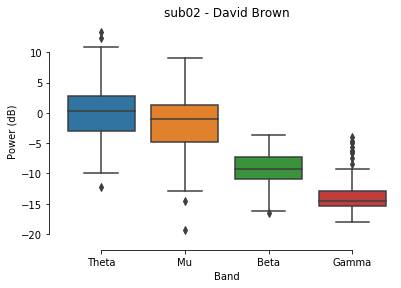

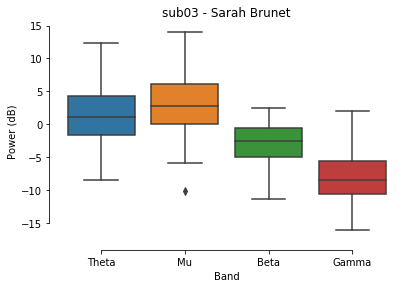

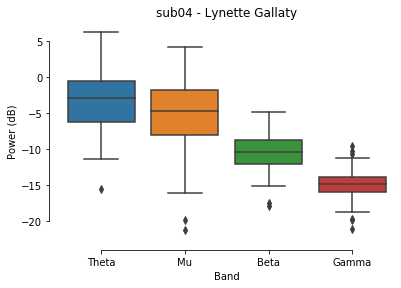

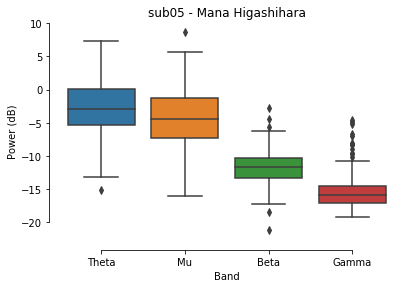

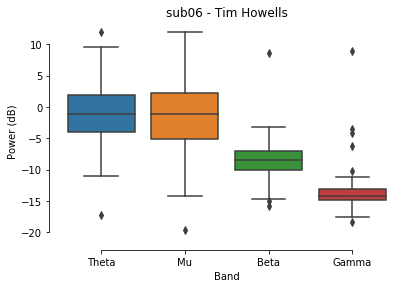

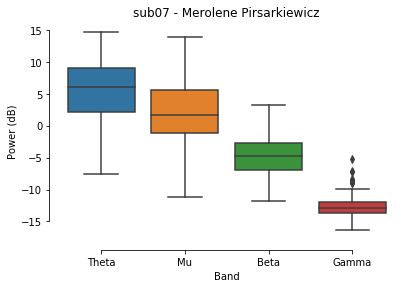

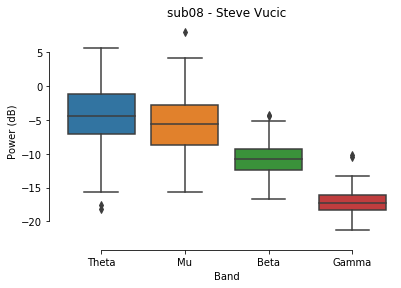

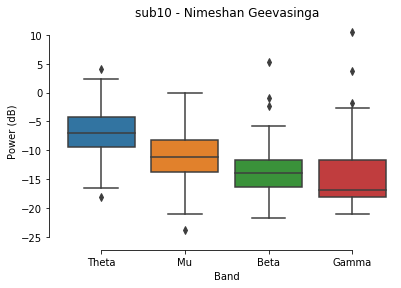

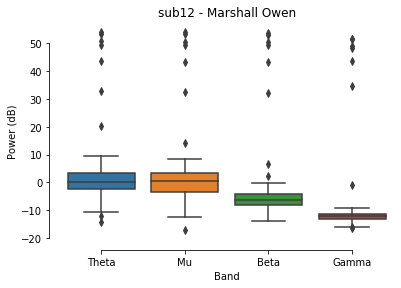

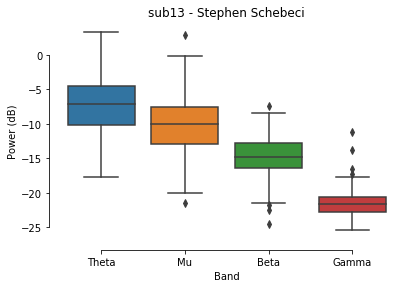

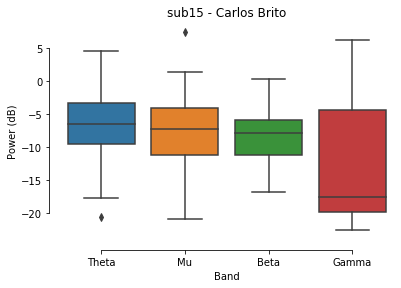

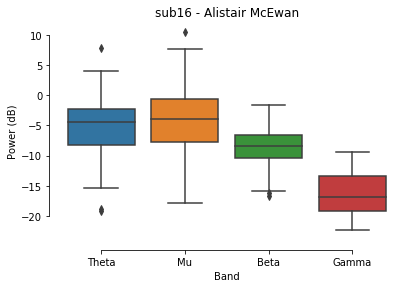

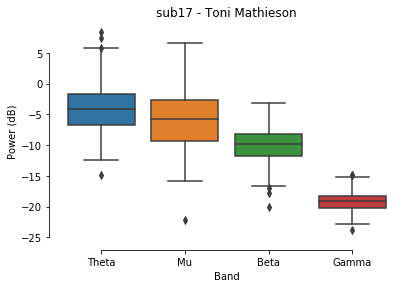

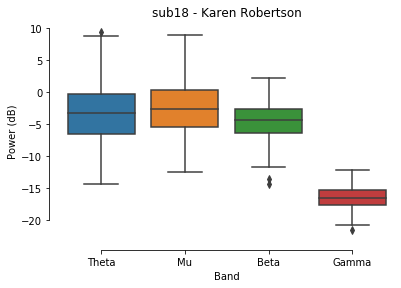

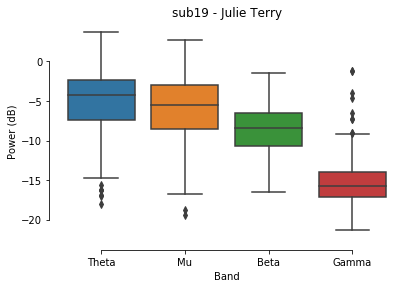

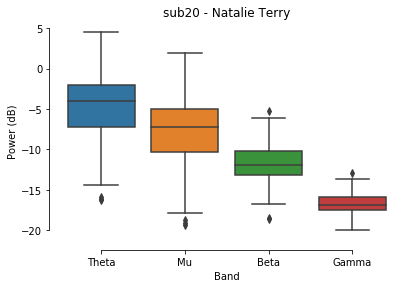

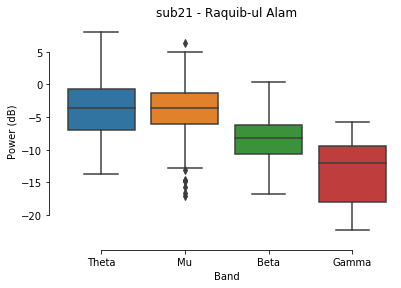

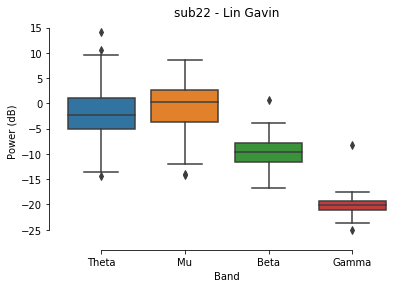

In [18]:
# df_melt = pd.read_excel('159-d1-power-long.xlsx')
subs = df_melt['sub'].unique()
i = 1
for sub in tqdm(subs):
    plt.figure()
    df = df_melt[df_melt['EEG'] == 'Raw']
    df = df[df['Method'] == 'Welch']
    df = df[df['Filter'] == 'Butterworth']
    df = df[df['sub'] == sub]
    df = df[df['Time'] == -750]
    sns.boxplot(x="Band", y="value", data=df)
    sns.despine(offset=10, trim=True)
    plt.xlabel('Band')
    plt.ylabel('Power (dB)')
    plt.title("{} - {}".format(sub, sub_map[sub]))
    plt.show()
#     plt.savefig('image-{}.jpg'.format(i))
    i = i + 1

# Compare with and without resampling

In [ ]:
df1 = pd.read_excel('153-d1-power-long.xlsx')
df1['Dataset'] = 'With resampling'
df2 = pd.read_excel('158-d1-power-long.xlsx')
df2['Dataset'] = 'Without resampling'
df_combined = pd.concat([df1, df2], axis=1)

In [ ]:
# df_melt = pd.read_excel('158-d1-power-long.xlsx')
subs = df_melt['sub'].unique()
i = 1
for sub in tqdm(subs):
    plt.figure()
    df = df_melt[df_melt['EEG'] == 'Raw']
    df = df[df['Method'] == 'Welch']
    df = df[df['Filter'] == 'Butterworth']
    df = df[df['sub'] == sub]
    df = df[df['Time'] == '-750']
    sns.boxplot(x="Band", y="value", data=df)
    sns.despine(offset=10, trim=True)
    plt.xlabel('Band')
    plt.ylabel('Power (dB)')
    plt.title("{} - {}".format(sub, sub_map[sub]))
#     plt.show()
    plt.savefig('image-{}.jpg'.format(i))
    i = i + 1